In [109]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 7)

The analysis question for this project is if age and time spent playing have a major factor in the likelihood that players subscribe to a gaming newsletter, as well as if there are other intermediate or correlated variables that also play a role. 

The data was taken from a form filled out by users on a PLAICraft Minecraft server. 

Firstly, only the relevant correlated variables are selected from the original dataset, excluding name, email, and gender, as gender is unlikely to have a correlation with either relevant factor. 

In [116]:
players_url <- "https://raw.githubusercontent.com/alorrain/DSCI_Final_Project/refs/heads/main/players.csv"
players <- read_csv(players_url) |>
select(experience, subscribe, played_hours, Age)
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,Age
<chr>,<lgl>,<dbl>,<dbl>
Pro,TRUE,30.3,9
Veteran,TRUE,3.8,17
Veteran,FALSE,0.0,17
Amateur,TRUE,0.7,21
⋮,⋮,⋮,⋮
Amateur,FALSE,0.0,17
Amateur,FALSE,2.3,17
Pro,TRUE,0.2,NA


A few plots are created to look at the trends and distributions between certain factors, that being age, experience, and hours played on the server, and their relation as to subscription status. 

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


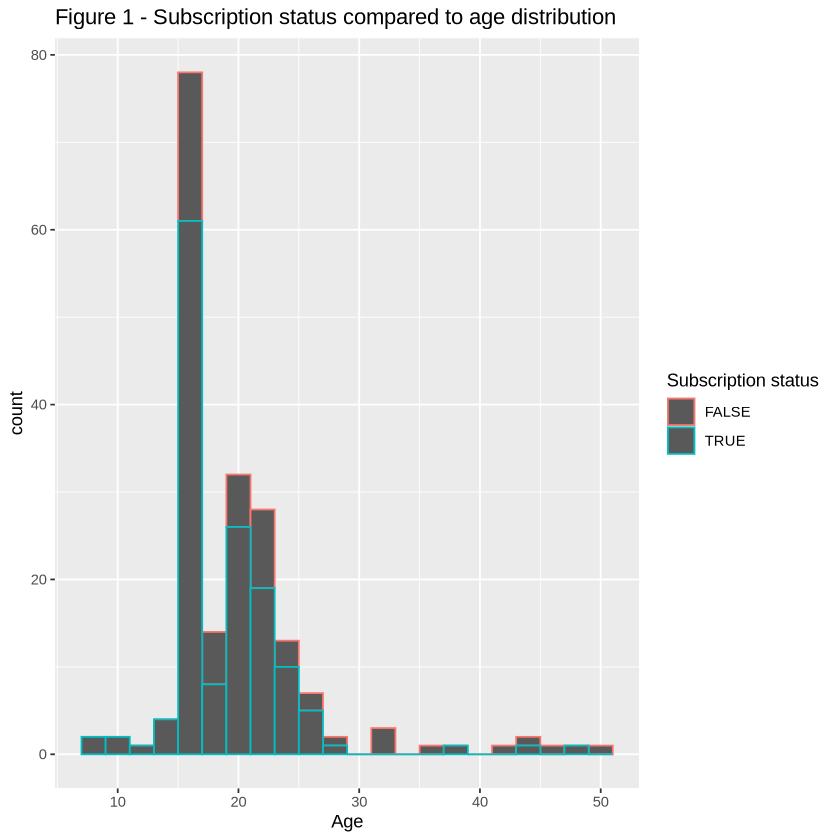

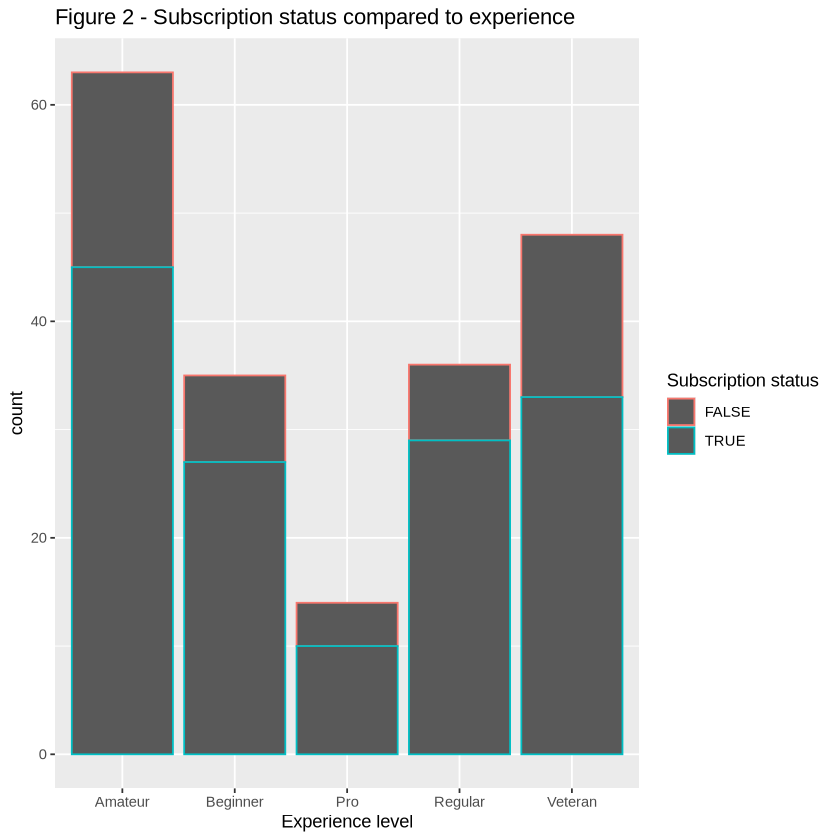

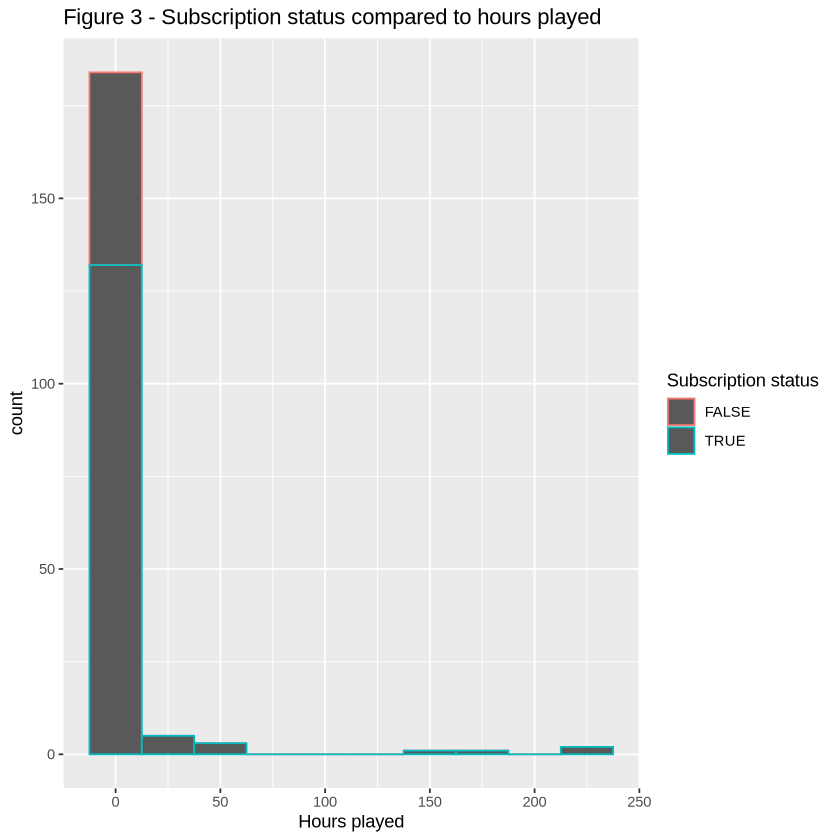

In [111]:
age_dist<- ggplot(players, aes(x=Age, color = subscribe)) + 
   geom_histogram(binwidth = 2) +
   labs(x="Age", color="Subscription status") +
   ggtitle("Figure 1 - Subscription status compared to age distribution")
age_dist
exp_dist<- ggplot(players, aes(x=experience, color = subscribe)) + 
   geom_bar() +
   labs(x="Experience level", color="Subscription status") +
   ggtitle("Figure 2 - Subscription status compared to experience")
exp_dist
time_dist<- ggplot(players, aes(x=played_hours, color = subscribe)) + 
   geom_histogram(binwidth = 25) +
   labs(x="Hours played", color="Subscription status") +
   ggtitle("Figure 3 - Subscription status compared to hours played")
time_dist

Figure Legend: 

Figure 1: This figure depicts the age distribution of users by subscription status. Blue indicates that the player is subscribed, and orange indicates that they are not. The data in this histogram was generated based off the age of each user and their subscription status. The distribution is strongly skewed right, with most of the cluster being around the ages of 15-25 years old. The peak in the graph for both subscribed and non-subscribed users is around the 18 year old mark. As the age of the users increase, there is a sharp decline in people in either category. 

Figure 2: This figure compares a players' experience level to the status of their subscription to find a possible correlation. The experience level range includes amateur, beginner, pro, regular, and veterans. The majority of the players fall under the "amateur" category. Each level of experience has a mix of subscribed (indicated in blue) and not subscribed (indicated in orange) in a ratio that remains roughly similar.

Figure 3: This figure shows a highly skewed distribution of hours played, showing that the majority of the individuals have only spent under 10 hours playing. Figure 3 also shows that players who have played over 25 hours are all subscribed. 

From Figure 1, we can find that experience does not appear to be a major factor in subscription status, as the ratio remains roughly the same across all experience levels. From Figure 2, it is difficult to tell the effect of age in subscription status. As for Figure 3, it appears that all users with with over 25 hours of playtime has subscribed, but it is difficult to see the distribution of players with less than 24 hours of playtime without a second graph. 

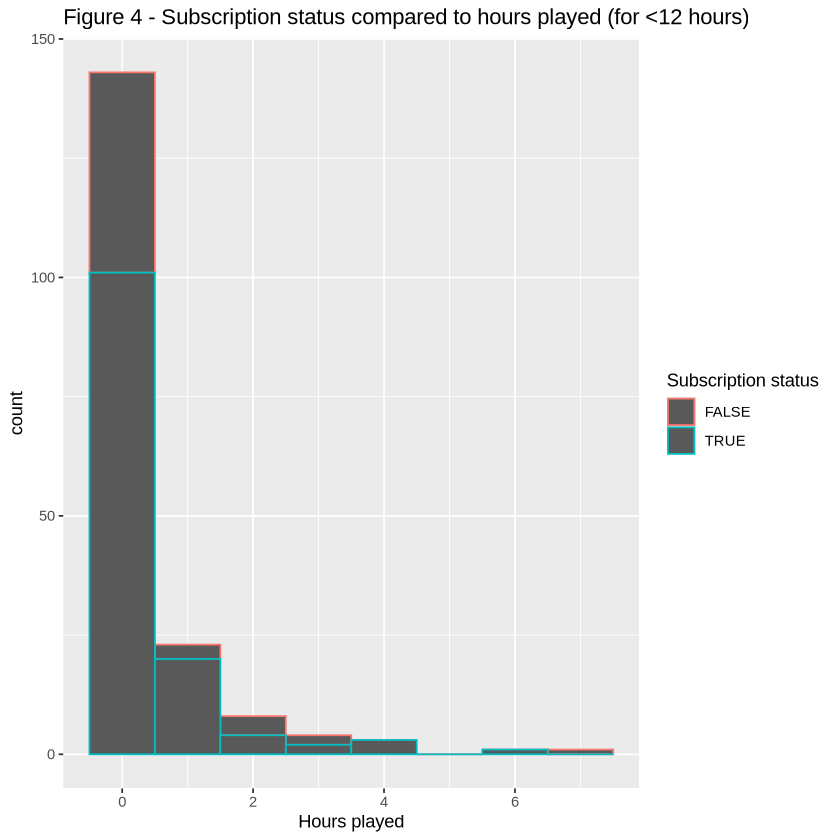

In [112]:
players_time <- players |>
filter(played_hours < 12)
time_dist_2<- ggplot(players_time, aes(x=played_hours, color = subscribe)) + 
   geom_histogram(binwidth = 1) +
   labs(x="Hours played", color="Subscription status") +
   ggtitle("Figure 4 - Subscription status compared to hours played (for <12 hours)")
time_dist_2

Figure Legend: 

Figure 4: Figure 4 shows the number of hours played and whether or not the player is subscribed. Subscribed players are indicated in blue, and players that are not subscribed are indicated in orange. This figure is right-skewed, with majority of the players having a lower play time (under 12 hours).

Figure 4 shows that the largest percentage of players unlikely to subscribe to a gaming newsletter are players who have played 0 hours, with a range from 0-3 hours having some amount of unsubscribed players and the highest outlier having a playtime around 7 hours. This will be taken into account in further analysis. For now, the relationship between age and hours played is also graphed.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


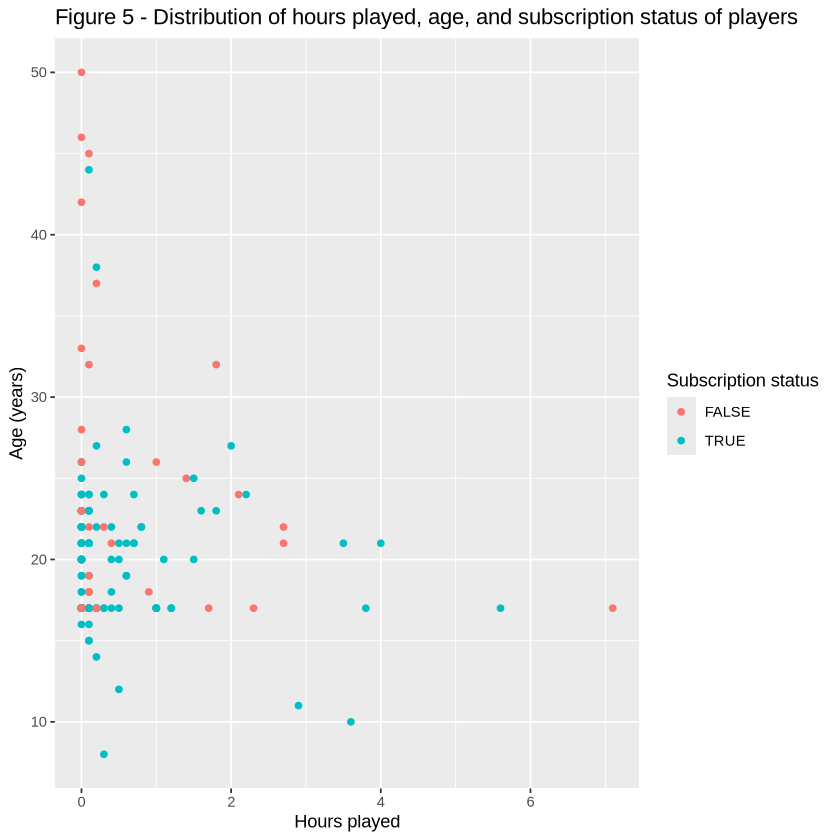

In [113]:
play_age <- ggplot(players_time, aes(x=played_hours, y=Age, color = subscribe)) + 
   geom_point() +
   labs(x="Hours played", y = "Age (years)", color="Subscription status") +
   ggtitle("Figure 5 - Distribution of hours played, age, and subscription status of players")

play_age

Figure Legend: 

Figure 5: In this figure, subscribers are represented in blue dots, whilst non-subscribers are represented in orange dots. The majority of the players have less than two hours played, regardless of subscription status, and fall in the age range of 15-25 years old. There are a few older players (above 35 years of age) that only have a few hours played on the game.  

From Figure 5, it is difficult to tell if there are any major patterns in subscription status. However, it is now visible that with one outlier, those who play for at least three hours are more likely to subscribe, and those who are under 15 are likely to subscribe. Using this data, a model is created.

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 29 rows.
               ✖ Assigned data has 30 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 30 to size 29.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





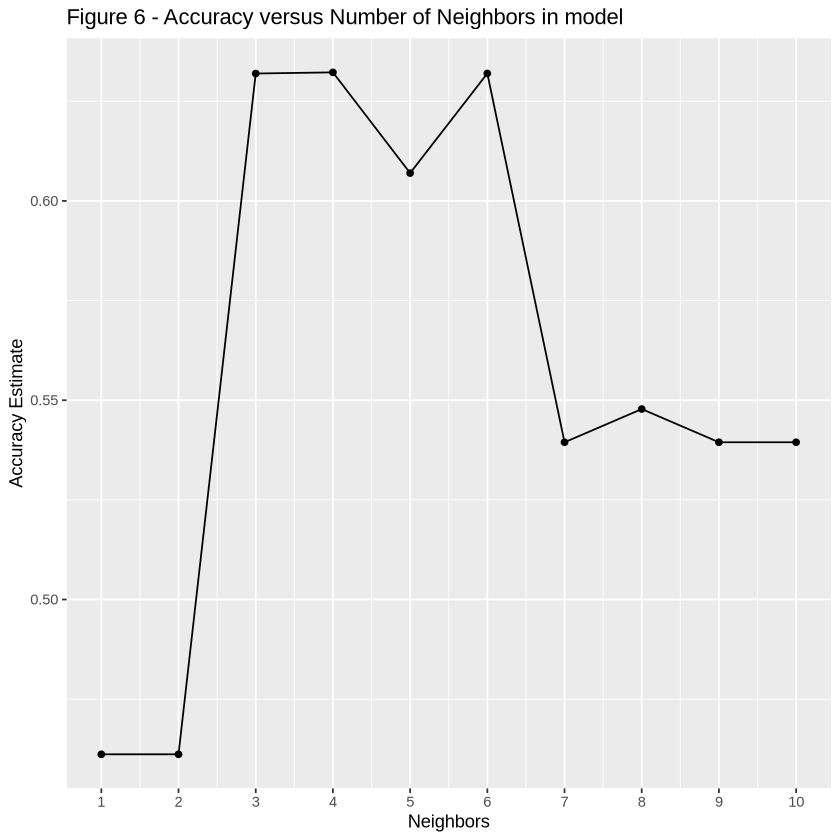

In [114]:
players <- players |>
mutate(subscribe = as_factor(subscribe))

knn_tune <- nearest_neighbor (weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

players_split <- initial_split(players, prop = .75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

players_recipe <- recipe(subscribe ~ Age + played_hours, data = players)
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

players_fit <- workflow() |>
add_recipe(players_recipe) |>
add_model(knn_tune) |>
tune_grid(resamples = players_vfold, grid = k_vals) |>
collect_metrics() |> 
filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(players_fit, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 10, by = 1)) +
       ggtitle("Figure 6 - Accuracy versus Number of Neighbors in model")
accuracy_versus_k

Figure Legend:

Figure 6: This figure shows the accuracy against the number of neighbors in the model. The figure depicts the relationship between the number of neighbors and model accuracy. The accuracy is low for both k=1 and k=2, but increases greatly at k=3. Beyond k=3, there is some fluctuation, but it tends to trend upward, peaking at k=8, then slightly declining.

This shows that the highest accuracy can be received with a neighbor count of 8, which the model is set to. The updated model is then tested for accuracy against the original data and visualised in a matrix.

In [115]:
knn_spec <- nearest_neighbor (weight_func = "rectangular", neighbors = 8) |>
set_engine("kknn") |>
set_mode("classification")

subscribe_fit <- workflow() |>
add_recipe(players_recipe) |>
add_model(knn_spec) |>
fit(data = players_train)

subscribe_predict <- predict(subscribe_fit, players_test) |>
bind_cols(players_test) |>
metrics(truth = subscribe, estimate = .pred_class)
subscribe_predict

subscribe_mat <- predict(subscribe_fit, players_test) |>
bind_cols(players_test) |>
conf_mat(truth = subscribe, estimate = .pred_class)
subscribe_mat

ERROR: [1m[33mError[39m in `bind_cols()`:[22m
[33m![39m Can't recycle `..1` (size 48) to match `..2` (size 49).


This confusion matrix shows that of the training set predictions, 28 of them are true positives and negatives, whilst in the errors, there are more false positives than false negatives (24.4% to 18.7%). The accuracy is roughly 57%, which is not very high. This suggests that the usage of age and played hours as predictors are not the most accurate method of predicting whether a player is subscribed. 

Ultimately, the high amount of errors in the confusion matrix, the very loose trends in the subscription class in the graphing of age and played hours, and the generally low accuracy with the most accurate K value used, it can be deduced that play time in hours and age, combined, are not particularly good parameters for predicting whether a player is likely to subscribe to the gaming newsletter. Given there was a weak but visible trend spotted in Figures 1, 3, and 4, this was not expected. It is possible that experience level and the non-investigated variable (gender) may play larger roles in predicting whether a user is likely to subscribe. 